In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import meshio
import pymapping
import pygmsh
import time
%matplotlib inline

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight",
          "savefig.pad_inches": 0.01}
plt.rcParams.update(params)

# 1-d mapping

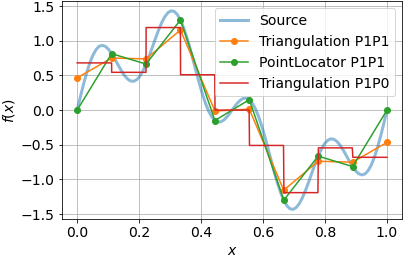

In [2]:
def mesh_unit_interval(N, eps=0):
    points = np.linspace(0 - eps, 1 + eps, N)
    cells_line = np.array([(i, i + 1) for i in range(len(points) - 1)], dtype=int)
    cells = {"line": cells_line}
    return meshio.Mesh(points, cells)

def get_P0_visualization(x, y, eps=1e-3):
    assert len(y) == len(x) - 1
    x_ = []
    y_ = []
    for i in range(len(x)):
        if i == 0 or i == len(x) - 1:
            x_.append(x[i])
        else:
            x_.append((1 - eps) * x[i])
            x_.append((1 + eps) * x[i])
    y_ = [val for val in y for _ in range(2)]
    return np.array(x_), np.array(y_)

# Source mesh
mesh_source = mesh_unit_interval(100)
f = np.sin(2 * np.pi * mesh_source.points) + 0.5 * np.sin(8 * np.pi * mesh_source.points)
mesh_source.point_data = {"f(x)": f}
plt.plot(mesh_source.points, f, label="Source", linewidth=3, alpha=0.5)

# Target mesh
mesh_target = mesh_unit_interval(10)

# P1P1 Mapping
mapper = pymapping.Mapper(verbose=False)
for intersection_type in ["Triangulation", "PointLocator"]:
    mapper.prepare(mesh_source, mesh_target, method="P1P1", intersection_type=intersection_type)
    res = mapper.transfer("f(x)")
    plt.plot(mesh_target.points, res.array(), "-o", label=intersection_type + " P1P1")

# P1P0
mapper.prepare(mesh_source, mesh_target, method="P1P0", intersection_type="Triangulation")
res = mapper.transfer("f(x)")
x_, y_ = get_P0_visualization(mesh_target.points, res.array())
plt.plot(x_, y_, "-", label="Triangulation P1P0")

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("mapping_1d.png", dpi=300)

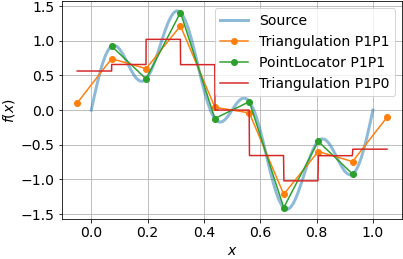

In [3]:
plt.plot(mesh_source.points, f, label="Source", linewidth=3, alpha=0.5)

# Target mesh
mesh_target = mesh_unit_interval(10, eps=0.05)

# P1P1 Mapping
mapper = pymapping.Mapper(verbose=False)
for intersection_type in ["Triangulation", "PointLocator"]:
    mapper.prepare(mesh_source, mesh_target, method="P1P1", intersection_type=intersection_type)
    res = mapper.transfer("f(x)")
    plt.plot(mesh_target.points, res.array(), "-o", label=intersection_type + " P1P1")

# P1P0
mapper.prepare(mesh_source, mesh_target, method="P1P0", intersection_type="Triangulation")
res = mapper.transfer("f(x)")
x_, y_ = get_P0_visualization(mesh_target.points, res.array())
plt.plot(x_, y_, "-", label="Triangulation P1P0")

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.grid()
plt.legend()
plt.tight_layout()

# 2-d mapping

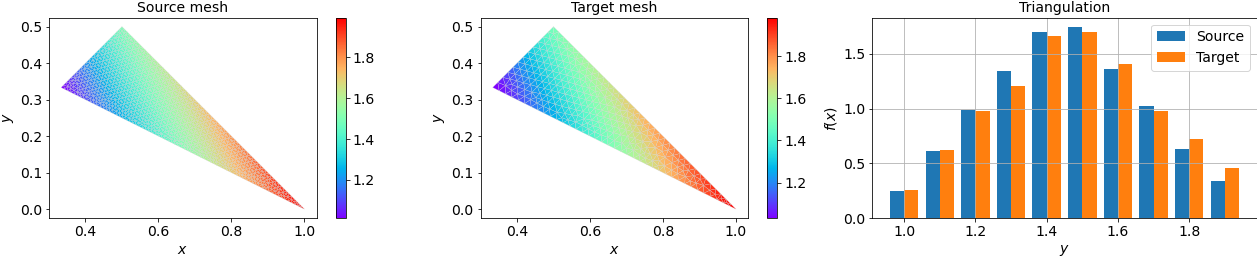

In [4]:
def mesh_TUB(h, recombine=False):
    geom = pygmsh.built_in.Geometry()
    polygon = geom.add_polygon([[1 / 3, 1 / 3, 0], [1, 0, 0], [0.5, 0.5, 0]], lcar=h)
    if recombine:
        geom.add_raw_code("Recombine Surface {%s};" % polygon.surface.id)
    mesh = pygmsh.generate_mesh(geom, dim=2, verbose=False, prune_z_0=True)
    return mesh

plt.figure(figsize=(18, 4))

# Source mesh
plt.subplot(1, 3, 1)
mesh_source = mesh_TUB(0.01, recombine=False)
f = 2 * mesh_source.points[:, 0] + mesh_source.points[:, 1]
mesh_source.point_data = {"f(x)": f}
mesh_source.cell_data["f(x)"] = []
for cells in mesh_source.cells:
    array = np.zeros(len(cells.data))
    for i, cell in enumerate(cells.data):
        centroid = np.mean(mesh_source.points[cell], axis=0)
        array[i] = 2 * centroid[0] + centroid[1]
    mesh_source.cell_data["f(x)"].append(array)

plt.tripcolor(mesh_source.points[:, 0], mesh_source.points[:, 1], mesh_source.cells_dict["triangle"], f, edgecolors="lightgray", cmap="rainbow")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title("Source mesh")
plt.tight_layout()

# Target mesh and P1P1 Mapping
intersection_type = "Triangulation"  # PointLocator, Triangulation
plt.subplot(1, 3, 2)
mesh_target = mesh_TUB(0.02)
mapper = pymapping.Mapper(verbose=False)
mapper.prepare(mesh_source, mesh_target, method="P1P1", intersection_type=intersection_type)
res = mapper.transfer("f(x)")
plt.tripcolor(mesh_target.points[:, 0], mesh_target.points[:, 1], mesh_target.cells_dict["triangle"], res.array(), edgecolors="lightgray", cmap="rainbow")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title("Target mesh")
plt.tight_layout()

# Quality accessment (only meaningful when meshes are both uniform)
plt.subplot(1, 3, 3)
plt.hist([f, res.array()], density=True, align="left", label=["Source", "Target"])
plt.xlabel("$y$")
plt.ylabel("$f(x)$")
plt.legend()
plt.grid()
plt.title(intersection_type)
plt.tight_layout()
# plt.savefig("mapping_2d.png", dpi=300)

## Scaling

In [ ]:
def mapping_time(mesh_source, mesh_target, method="P1P1", intersection_type="PointLocator"):
    mapper = pymapping.Mapper(verbose=False)
    t = time.time()         
    mapper.prepare(mesh_source, mesh_target, method=method, intersection_type=intersection_type)
    res = mapper.transfer("f(x)")
    return time.time() - t

# Fix source mesh and vary target mesh
mesh_source = mesh_TUB(0.001)
f = 2 * np.sin(mesh_source.points[:, 0]) + mesh_source.points[:, 1]
mesh_source.point_data = {"f(x)": f}

h_target = np.logspace(-3, -2, 5)
npoints_target = np.zeros(len(h_target))
t = np.zeros(len(h_target))

method = "P1P1"
for intersection_type in ["PointLocator", "Triangulation"]:
    for i in range(len(h_target)):
#         print(f"Working on {intersection_type} with h = {h_target[i]}")
        mesh_target = mesh_TUB(h_target[i])
        npoints_target[i] = len(mesh_target.points)
        t[i] = mapping_time(mesh_source, mesh_target, method, intersection_type)
    plt.loglog(npoints_target, t, "-o", label=intersection_type)

plt.legend()
plt.grid()
plt.xlabel("# of target points")
plt.ylabel("$t$")
plt.title(method)
plt.tight_layout()

In [ ]:
# Fix target mesh and vary source mesh
mesh_target = mesh_TUB(0.01)

h_source = np.logspace(-3, -2, 5)
ncells_source = np.zeros(len(h_source))
t = np.zeros(len(h_source))

method = "P1P1"
for intersection_type in ["PointLocator", "Triangulation"]:
    for i in range(len(h_source)):
        mesh_source = mesh_TUB(h_source[i])
        f = 2 * np.sin(mesh_source.points[:, 0]) + mesh_source.points[:, 1]
        mesh_source.point_data = {"f(x)": f}
        ncells_source[i] = len(mesh_source.cells["triangle"])
        t[i] = mapping_time(mesh_source, mesh_target, method, intersection_type)
    plt.loglog(ncells_source, t, "-o", label=intersection_type)

plt.legend()
plt.grid()
plt.xlabel("# of source cells")
plt.ylabel("$t$")
plt.title(method)
plt.tight_layout()

# Validation example

The "numerical diffusion in a rotating square" problem considered in [Bussetta, P.; Boman, R. & Ponthot, J.-P. Efficient 3D data transfer operators based on numerical integration. International Journal for Numerical Methods in Engineering, Wiley, 2014, 102, 892-929](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.4821).

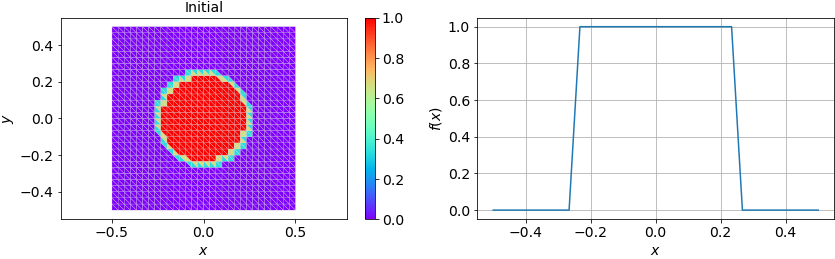

In [7]:
def mesh_square(Nx=31):
    geom = pygmsh.built_in.Geometry()
    poly = geom.add_polygon(
        [[-0.5, -0.5, 0.0], [0.5, -0.5, 0.0], [0.5, 0.5, 0.0], [-0.5, 0.5, 0.0]]
    )
    geom.set_transfinite_surface(poly.surface, size=[Nx, Nx])
    mesh = pygmsh.generate_mesh(geom, dim=2, verbose=False, prune_z_0=True)
    assert len(mesh.cells_dict["triangle"] == (Nx - 1)**2)
    pymapping.cleanup_mesh_meshio(mesh)
    
    # Source field
    mesh.point_data["f(x)"] = np.zeros(len(mesh.points))
    for i in range(len(mesh.points)):
        x, y = mesh.points[i]
        r = np.sqrt(x**2 + y**2)
        r0 = 0.25
        if r < r0 or np.isclose(r, r0):
            mesh.point_data["f(x)"][i] = 1
    return mesh

def apply_rotation(mesh, theta=np.pi / 4):
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = mesh.points.copy()
    for i in range(len(points)):
        points[i] = R @ points[i]
    return meshio.Mesh(points, mesh.cells)

def values_along_y0(mesh):
    mask = np.isclose(mesh.points[:, 1], 0)
    x = mesh.points[:, 0][mask]
    f = mesh.point_data["f(x)"][mask]
    ind = np.argsort(x)
    return x[ind], f[ind]

mesh = mesh_square()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.tripcolor(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"], mesh.point_data["f(x)"], edgecolors="lightgray", cmap="rainbow")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.axis("equal")
plt.title("Initial")
plt.colorbar()

plt.subplot(1, 2, 2)
x, f = values_along_y0(mesh)
plt.plot(x, f)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.grid()
plt.tight_layout()

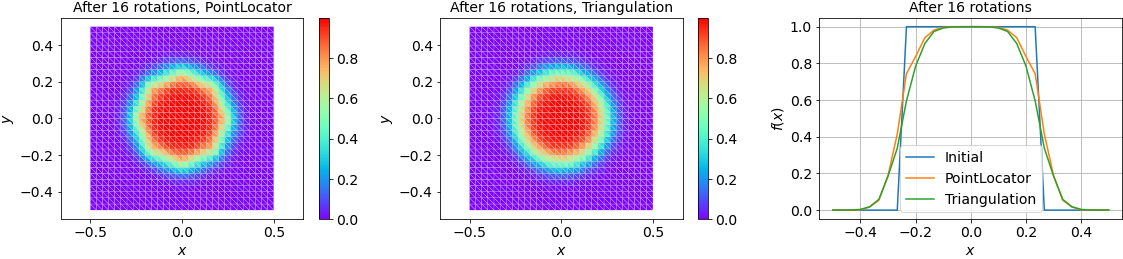

In [8]:
def mapping_rotating_square(n_rotation=16, intersection_type="PointLocator"):
    mesh = mesh_square()
    mapper = pymapping.Mapper(verbose=False)
    for _ in range(n_rotation):
        mesh_target = apply_rotation(mesh)
        mapper.prepare(mesh, mesh_target, method="P1P1", intersection_type=intersection_type)
        res = mapper.transfer("f(x)", default_value=0)
        mesh = res.mesh_meshio()
    return mesh

n_rotation = 16
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

x, f = values_along_y0(mesh_square())
ax[2].plot(x, f, label="Initial")

for i, intersection_type in enumerate(["PointLocator", "Triangulation"]):
    mesh = mapping_rotating_square(n_rotation, intersection_type)
    im = ax[i].tripcolor(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"], mesh.point_data["f(x)"], edgecolors="lightgray", cmap="rainbow")
    ax[i].set_xlabel("$x$")
    ax[i].set_ylabel("$y$")
    ax[i].axis("equal")
    ax[i].set_title(f"After {n_rotation:d} rotations, {intersection_type}")
    fig.colorbar(im, ax=ax[i])
    
    x, f = values_along_y0(mesh)
    ax[2].plot(x, f, label=f"{intersection_type}")

ax[2].set_xlabel("$x$")
ax[2].set_ylabel("$f(x)$")
ax[2].legend()
ax[2].set_title(f"After {n_rotation:d} rotations")
ax[2].grid()
fig.tight_layout()